# Generate n-sized sample of points on surface of a sphere

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d # for the wireframe
import GPy

## Generate points on surface of sphere 

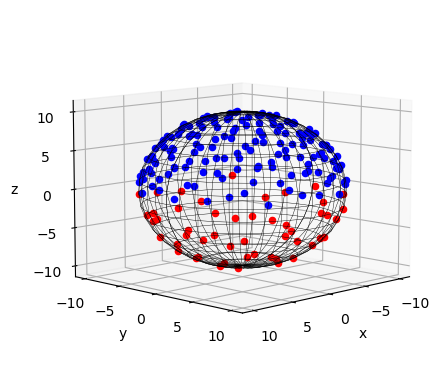

In [2]:
from numpy import pi, cos, sin, arccos, arange
import mpl_toolkits.mplot3d
import matplotlib.pyplot as pp

n = 200

def psample_sphere(npoints):
    indices = arange(0, npoints, dtype=float) + 0.5
    phi = arccos(1 - 2*indices/npoints)
    theta = pi * (1 + 5**0.5) * indices
    x = 10 * cos(theta) * sin(phi) # converting from spherical to cartesian
    y = 10 * sin(theta) * sin(phi) # rho = 10
    z = 10 * abs(cos(phi))
    return np.array([x,y,z])

def nsample_sphere(npoints):
    indices = arange(0, npoints, dtype=float) + 0.5
    phi = arccos(1 - 2*indices/npoints)
    theta = pi * (1 + 5**0.5) * indices
    x = 10 * cos(theta) * sin(phi) # converting from spherical to cartesian
    y = 10 * sin(theta) * sin(phi) # rho = 10
    z = -10 * abs(cos(phi))
    return np.array([x,y,z])


#pp.figure().add_subplot(111, projection='3d').scatter(x, y, z);
#pp.show()

## get a sample of size n. Note that the function sample_sphere gives 3 arrays for 
# all xpoints, ypoints, zpoints respectively. pca function from scikitlearn believes it is 3 observations with 
# n features
sample1 = psample_sphere(0.75*n)
sample2 = nsample_sphere(0.25*n)
#print(sample)
xs = np.concatenate((sample1[0], sample2[0]))
ys = np.concatenate((sample1[1], sample2[1]))
zs = np.concatenate((sample1[2], sample2[2]))


## set inputs for the wireframe
ph = np.linspace(0, np.pi, 20)
th = np.linspace(0, 2 * np.pi, 40)
a = np.outer(10*np.sin(th), np.cos(ph)) ## make sure the constant matches the constant (rho) in the sphere function
b = np.outer(10*np.sin(th), np.sin(ph))
c = np.outer(10*np.cos(th), np.ones_like(ph))

###### set up plotting area
#fig = plt.figure()
#ax = fig.add_subplot(projection = '3d')
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'})
## plot the wireframe
ax.plot_wireframe(a,b,c, color='k',linewidth = 0.3 , rstride=1, cstride=1)


## plot the points from the n-sized sample
for i in np.arange(1,n,1):
    xp = xs[i]
    yp = ys[i]
    zp = zs[i]
    if zs[i] > 0:
        ax.scatter(xp, yp, zp, marker = 'o', c = 'blue') # points in northern hemisphere are blue
    else :
        ax.scatter(xp, yp, zp, marker = 'o', c = 'red') # points in southern hemisphere are red
ax.view_init(elev = 9, azim = 45)

## axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

#plt.plot(xs[0], ys[0], zs[0], marker = '*', color = 'k')

plt.show()





In [3]:
phi0 = np.arccos(np.linspace(-1,1,10)) #generate phi values: 0 <phi< pi, equally divide the sphere int0 10 latitude lines
phi = np.tile(phi0, 20)

### Prepare sphere data for PCA

In [4]:
## The function sample_sphere gives 3 arrays for all xpoints, ypoints, zpoints respectively. 
# pca function from scikitlearn believes it is 3 observations with n features
# However is it actually a 3-feature sample with n observations (the other way around). To fix this:
#n = 100
# initialise an empty array of desired dimension
sphere = np.ones(shape = (n,3))

# make each point (xi,yi,zi) its own array
for i in range(n):
    sphere[i, 0] = xs[i]
    sphere[i, 1] = ys[i]
    sphere[i, 2] = zs[i] 
    
# sphere
# ^ this is now the data frame to be used in pca
# the pca function understands this as n observations with 3 dimensions

### Make vector of labels 

In [5]:
uhem = sphere[sphere[:,2]>0]
lhem = sphere[sphere[:,2]<0]
Y = np.vstack((uhem,lhem))
labels = np.hstack((np.zeros(uhem.shape[0]), np.ones(lhem.shape[0])))


In [6]:
print(xs[0], ys[0], zs[0])
print(Y[0])

0.41773650774031323 -1.0744231470839711 9.933333333333334
[ 0.41773651 -1.07442315  9.93333333]


# Perform PCA on the spherical sample


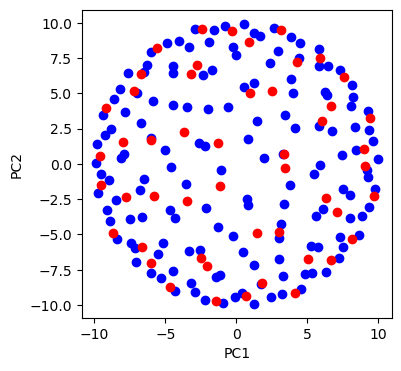

In [7]:
# Original data: 3 dimensional consisting of covariates x, y, and z
# We will reduce dimensionality of the data to 2 so they sphere will be 'squashed' to a 2-d plot
# and the points will be coloured based on if they are in the northern or southern hemisphere of the sphere

from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

pca.fit(Y)
sphere_pca = pca.transform(Y)

plt.figure(figsize = (4,4)) # select figure size

#plt.scatter(sphere_pca[:,0], sphere_pca[:,1])

#for i in np.arange(1,n,1) :
#    if zs[i] > 0 :
#        plt.scatter(sphere_pca[i,0], sphere_pca[i,1], c = 'blue')
#    else :
#        plt.scatter(sphere_pca[i,0], sphere_pca[i,1], c = 'red')

for i in np.arange(1,n,1) :
    if Y[i,2] > 0 :
        plt.scatter(sphere_pca[i,0], sphere_pca[i,1], c = 'blue')
    else :
        plt.scatter(sphere_pca[i,0], sphere_pca[i,1], c = 'red')

#plt.plot(sphere_pca[0,0], sphere_pca[0,1], c = 'k', marker = '*')
        
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [8]:
print(sphere.shape)
print(sphere_pca.shape)

(200, 3)
(200, 2)


# Apply GP-LVM to spherical sample

### GP-LVM with Linear kernel ; PCA

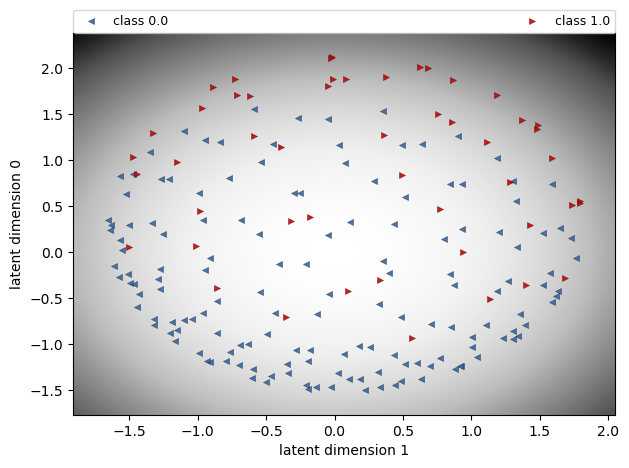

In [9]:
np.random.seed(12345)

# latent dimension = q
q = 2

#sphere gplvm
s_gplvm = GPy.models.GPLVM(Y, q, kernel = GPy.kern.Linear(q))

s_gplvm

s_gplvm.plot_latent(labels=labels)

plt.show()

## GP-LVM with RBF kernel and optimisation

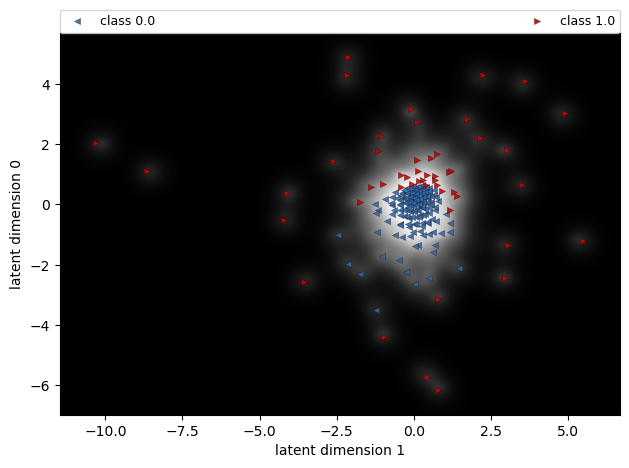

In [10]:
# latent dimension = q
q = 2

#sphere gplvm
s_gplvm = GPy.models.GPLVM(Y, q, kernel = GPy.kern.RBF(q))

#s_gplvm

s_gplvm.optimize(messages=1)

s_gplvm.plot_latent(labels=labels)

plt.show()
